# CPU Cycles and Degrees of Data Selectivity

This experiment evaluates the cost of total CPU cycles during transferring different percentages of the whole **dataset (1GB)** from multiple servers to a client using a simple data filtering function. The transmission size range from 10% to 90% of the dataset, which is generated/filled with only digits under uniform distribution, to represent different degrees of data selectivity.

## Data Filtering Function

The data filtering function we evaluated in this experiment is a lambda function
```python
lambda v: int(chr(v)) <= BIGGEST
```
where `BIGGEST` between 0 and 8 is for controlling the degree of data selectivity.

For each byte in the dataset, we use the above function to check if the current byte should be transmitted. Specifically, a smaller `BIGGEST` results in high data selectivity while bigger `BIGGEST` permits more bytes in the dataset to be transmitted meaning low data selectivity in other words.

## Experiment Setup

### Machine Configuration

1 client node and 8 server nodes are all the same machine type from cloudlab:

**xl170**   Intel Broadwell, 10 core, 1 disk

---
```
CPU     Ten-core Intel E5-2640v4 at 2.4 GHz 
RAM     64GB ECC Memory (4x 16 GB DDR4-2400 DIMMs)
Disk    Intel DC S3520 480 GB 6G SATA SSD 
NIC     Two Dual-port Mellanox ConnectX-4 25 GB NIC (PCIe v3.0, 8 lanes
```
---


### Architecture

![experiment_setup](../images/experiment_setup_1GB.png)

## Results

Let's see the aggregated CPU cycles on both the client and the all the relavent servers in each test.

In [1]:
from IPython.display import display, Markdown

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
_AVG = 'avg'
_STD = 'std'

def gen_df(json_file):
    FILE_PATH = '../backups/pyben-nio/' + json_file
    
    with open(FILE_PATH, 'r') as fobj:
        df = pd.read_json(fobj)

    for size in df.columns:
        size_df = df[size]

        for nservs in size_df.index:
            nservs_df = size_df[nservs]

            client_bitrates = nservs_df['bitrate']['client']
            nservs_df['bitrate']['client'] = \
                {_AVG: np.mean(client_bitrates), _STD: np.std(client_bitrates, ddof=1)}

            client_cycles = nservs_df['cycles']['client']
            nservs_df['cycles']['client'] = \
                {_AVG: np.mean(client_cycles), _STD: np.std(client_cycles, ddof=1)}

            servers_bitrates = []
            servers_cycles = []
            for serv_idx in range(nservs):
                bitrates = [arr[serv_idx] for arr in nservs_df['bitrate']['servers']]
                servers_bitrates.append(
                    {_AVG: np.mean(bitrates), _STD: np.std(bitrates, ddof=1)})

                cycles = [arr[serv_idx] for arr in nservs_df['cycles']['servers']]
                servers_cycles.append(
                    {_AVG: np.mean(cycles), _STD: np.std(cycles, ddof=1)})

            nservs_df['bitrate']['servers'] = servers_bitrates
            nservs_df['cycles']['servers'] = servers_cycles
            
    return df

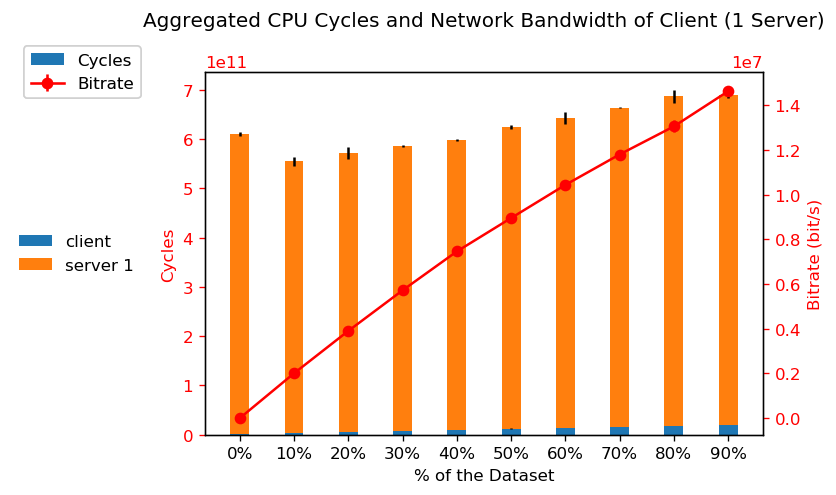

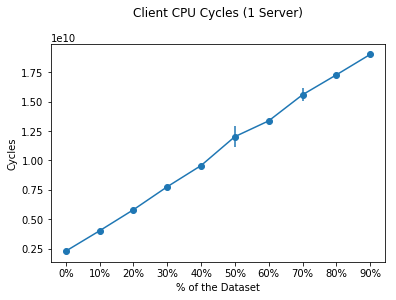

---

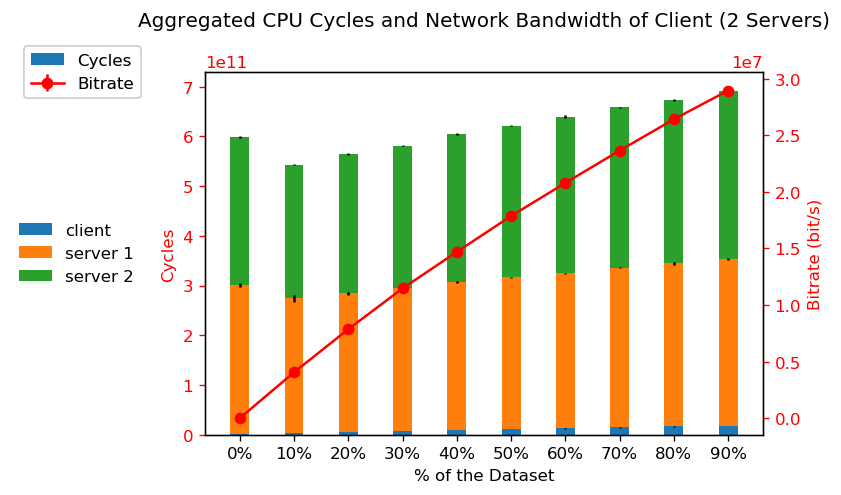

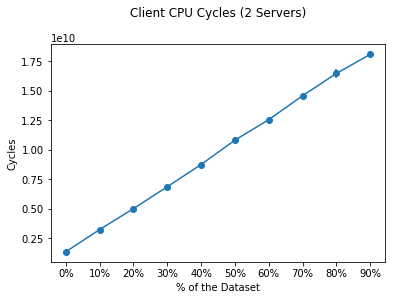

---

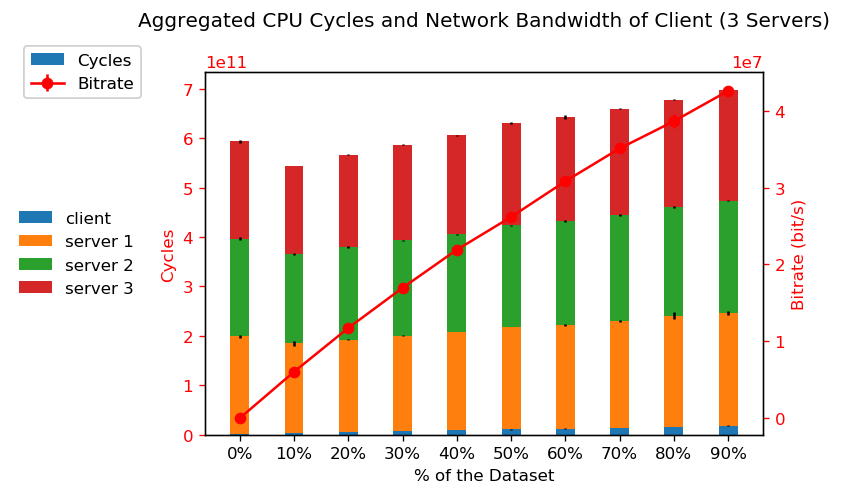

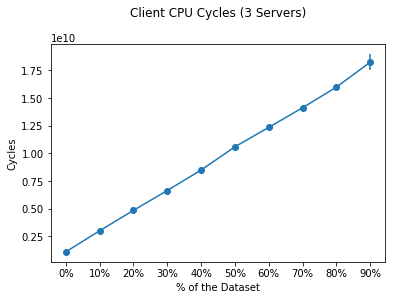

---

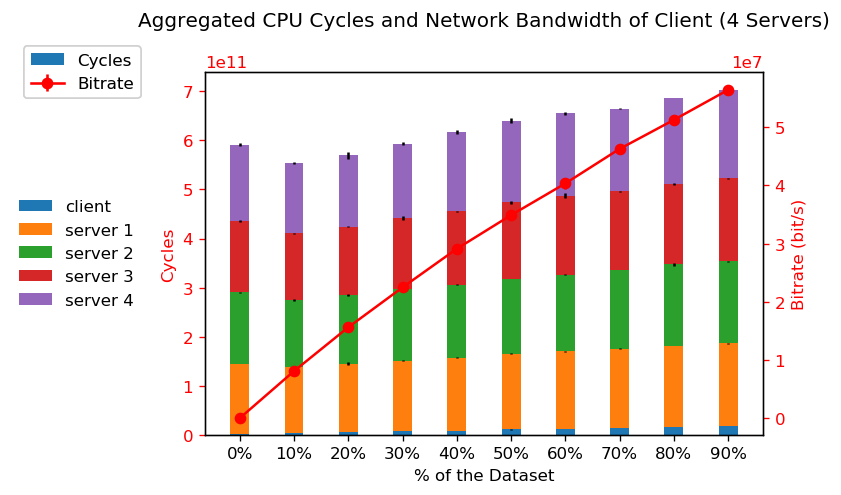

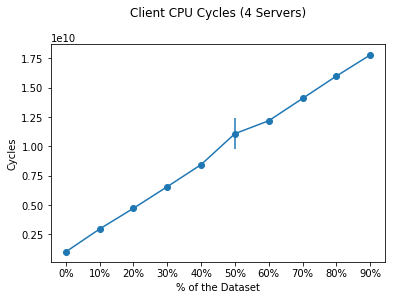

---

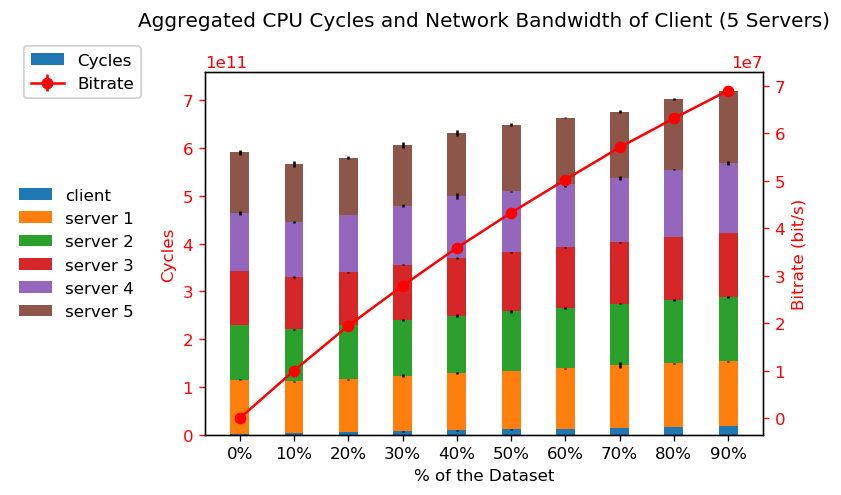

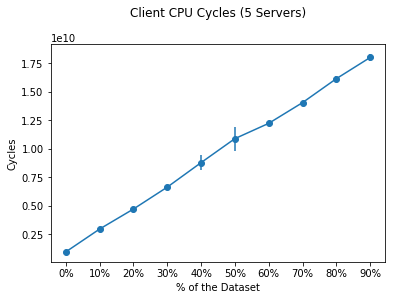

---

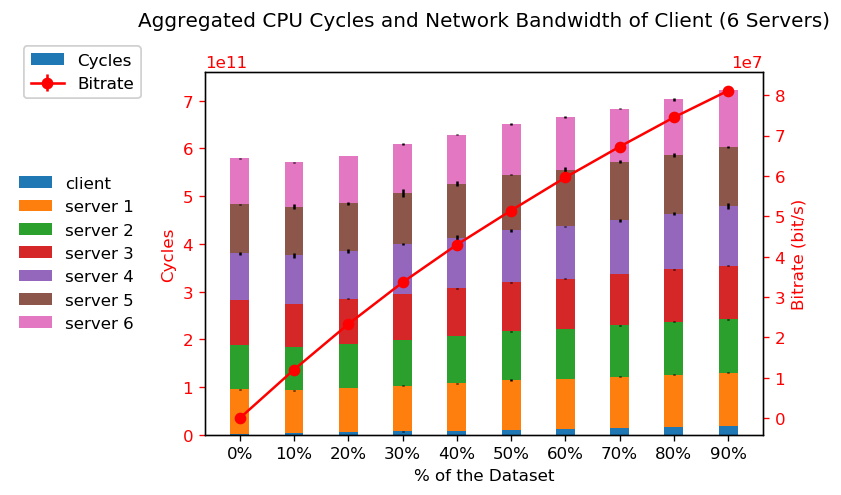

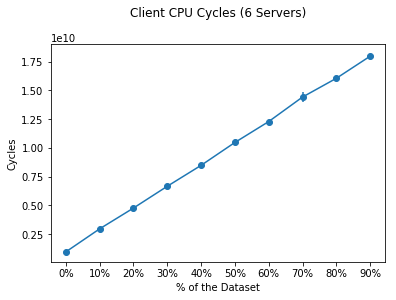

---

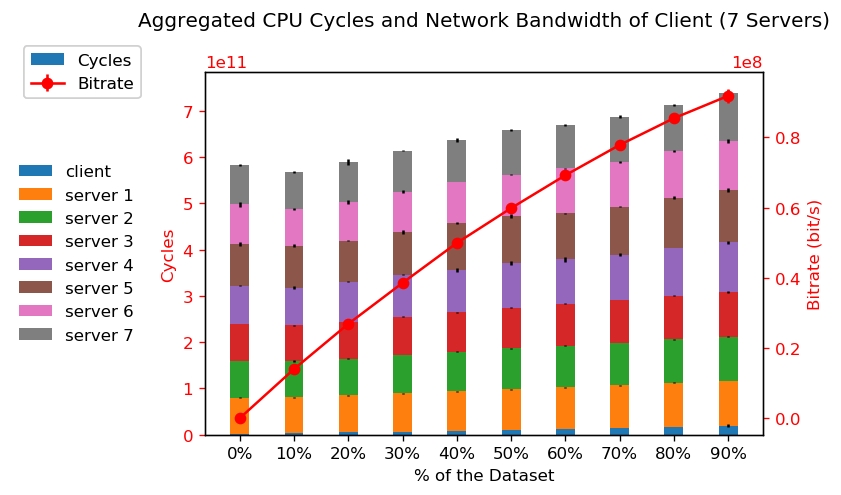

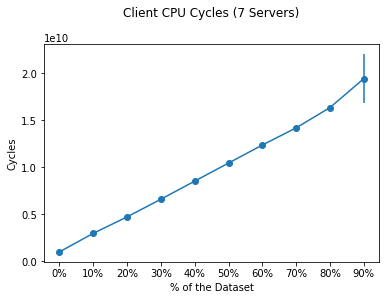

---

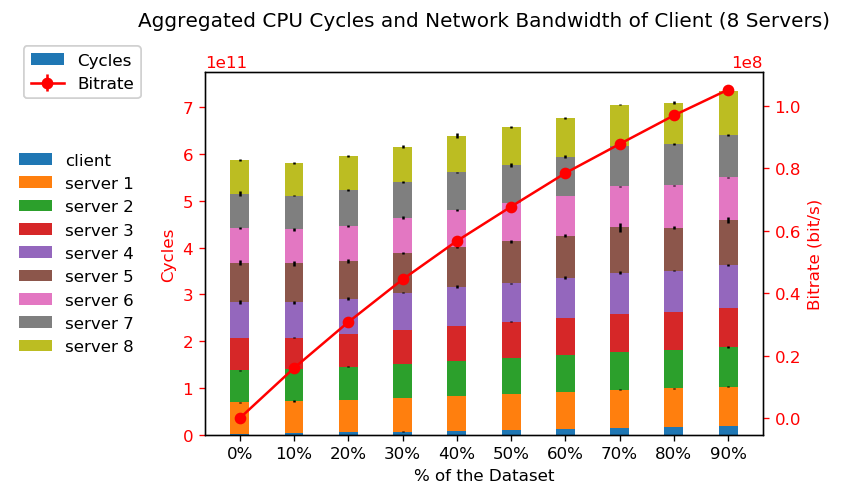

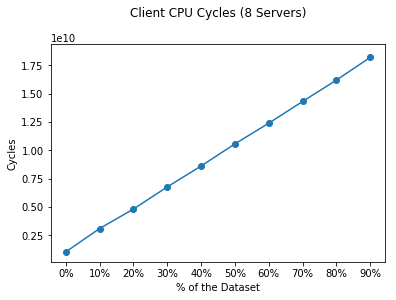

---

In [3]:
df = gen_df('output_50M_isolcpus_iostat_512M_8servs/result.json')
N = len(df.columns)
ind = np.arange(N)
WIDTH = 0.35
YAX_CLR = 'r'

for num_servs in range(1, len(df.index) + 1):
    fig, ax1 = plt.subplots()
    
    # Change the size of figure
    # See https://stackoverflow.com/a/4306340
    fig.set_dpi(120)
    
    # Draw bins for Cycles
    cycle_bars = []
    
    ## Plot client cycles
    client_cycle_avgs = \
        [df[size][num_servs]['cycles']['client']['avg'] for size in df.columns]
    client_cycle_stds = \
        [df[size][num_servs]['cycles']['client']['std'] for size in df.columns]
    
    cycle_bars.append(
        ax1.bar(ind,
                client_cycle_avgs,
                WIDTH,
                yerr=client_cycle_stds))
    last_bottom = client_cycle_avgs
    
    ## Plot servers cycles
    for serv_idx in range(num_servs):
        server_cycle_avgs = \
            [df[size][num_servs]['cycles']['servers'][serv_idx]['avg'] for size in df.columns]
        server_cycle_stds = \
            [df[size][num_servs]['cycles']['servers'][serv_idx]['std'] for size in df.columns]
            
        cycle_bars.append(
            ax1.bar(ind,
                    server_cycle_avgs,
                    WIDTH,
                    bottom=last_bottom,
                    yerr=server_cycle_stds))
        last_bottom = np.sum([last_bottom, server_cycle_avgs], axis=0)
    
    ax1.set_ylabel('Cycles', color=YAX_CLR)
    ax1.tick_params('y', colors=YAX_CLR)
    ax1.set_xlabel('% of the Dataset')
    
    plt.legend(
        cycle_bars,
        ['client'] + ['server ' + str(idx) for idx in df.index],
        loc=5,
        bbox_to_anchor=(-0.1, 0.5),
        frameon=False)
    
    
    # Draw bitrate for client
    ax2 = ax1.twinx()
    
    client_bitrate_avgs = \
        [df[size][num_servs]['bitrate']['client']['avg'] for size in df.columns]
    client_bitrate_stds = \
        [df[size][num_servs]['bitrate']['client']['std'] for size in df.columns]
    
    bitrate_bar = ax2.errorbar(
        ind,
        client_bitrate_avgs,
        yerr=client_bitrate_stds,
        color=YAX_CLR,
        fmt='-o')
    
    ax2.set_ylabel('Bitrate (bit/s)', color=YAX_CLR)
    ax2.tick_params('y', colors=YAX_CLR)

    plt.gca().add_artist(plt.legend(
        [cycle_bars[0], bitrate_bar],
        ['Cycles', 'Bitrate'],
        loc=5,
        bbox_to_anchor=(-0.1, 1)))
    
    plt.xticks(ind, df.columns)
    plt.title(
        'Aggregated CPU Cycles and Network Bandwidth of Client (' + str(num_servs) + \
        ' Server' + ('s' if num_servs > 1 else '') + ')', y=1.1)
    plt.show()
    
    
    # Plot the client cycles in a separated figure
    fig_client_cycles, ax_client_cycles = plt.subplots()
    
    ax_client_cycles.errorbar(ind,
        client_cycle_avgs,
        yerr=client_cycle_stds,
        fmt='-o')
    
    ax_client_cycles.set_ylabel('Cycles')
    ax_client_cycles.set_xlabel('% of the Dataset')
    
    plt.xticks(ind, df.columns)
    plt.title(
        'Client CPU Cycles (' + str(num_servs) + \
        ' Server' + ('s' if num_servs > 1 else '') + ')', y=1.1)
    plt.show()
    
    display(Markdown('---'))

## Further Analysis

We want to use linear least-squares regression to fit the CPU cycle increasement of different number of servers.

The model we want to fit in is
```
f(x) = ax + b
```

where `f(x)` is the observed CPU cycles of running the server program, `a` is the consumption of total CPU cycles to transmit the whole dataset, `b` is rest cycles used for scanning and filtering the data which supposed to be a constant.

We use R-squared to evaluate the quality of the regression model.

---
R-squared a statistical measure of how close the data are to the fitted regression line. It is always between 0 and 100%:

- 0% indicates that the model explains none of the variability of the response data around its mean.
- 100% indicates that the model explains all the variability of the response data around its mean.

[source](http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit)

---

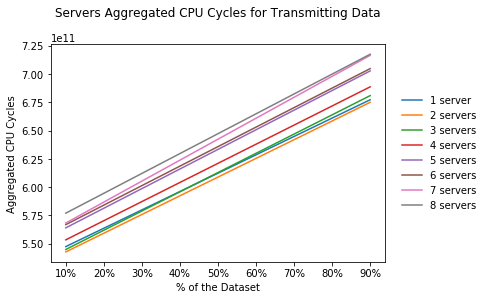

r-squareds: [0.98813148260682315, 0.99756051808836832, 0.99495360614903383, 0.98991583171527542, 0.99208630679758469, 0.99629945938944209, 0.99341898115053939, 0.99255642310183501]


In [4]:
from scipy.stats import linregress

pstgs = np.arange(0.1, 1, 0.1)

p1_args = []
r_squareds = []

for num_servs in range(1, len(df.index) + 1):
    sum_cycle_avgs = []
    for serv_idx in range(num_servs):
            server_cycle_avgs = \
                [df[size][num_servs]['cycles']['servers'][serv_idx]['avg'] for size in df.columns[1:]]
            sum_cycle_avgs = np.sum([sum_cycle_avgs, server_cycle_avgs], axis=0)

    slope, intercept, r_value, p_value, std_err = linregress(pstgs, sum_cycle_avgs)
    r_squareds.append(r_value**2)
    args = [slope, intercept]
    p1_args.append(args)
    p1 = np.poly1d(args)

    plt.plot(pstgs, p1(pstgs), '-',
             label=str(num_servs) + ' server' + ('s' if num_servs > 1 else ''))
    
plt.legend(
    loc=5,
    bbox_to_anchor=(1.3, 0.5),
    frameon=False)

plt.ylabel('Aggregated CPU Cycles')
plt.xlabel('% of the Dataset')
plt.xticks(pstgs, [str(int(ps * 100)) + '%' for ps in pstgs])
plt.title('Servers Aggregated CPU Cycles for Transmitting Data', y=1.1)

plt.show()

print('r-squareds: ' + repr(r_squareds))

Since for the same number of servers, the source of the difference of `Aggregated CPU Cycles` is the different size of the data transmission. We can then distill the CPU cycles consumption just for sending the data from the servers.

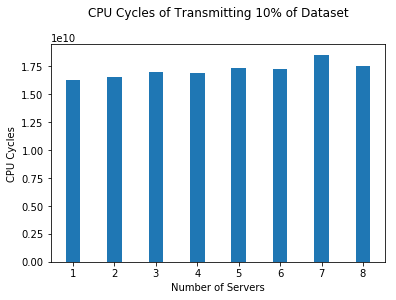

In [5]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] * 0.1 for args in p1_args], WIDTH)

ax.set_ylabel('CPU Cycles')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles of Transmitting 10% of Dataset', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

On the other hand, we can estimate how much does the cycles for transmitting the whole dataset account for the rest of work including data scaning and filtering consumed by the server program.

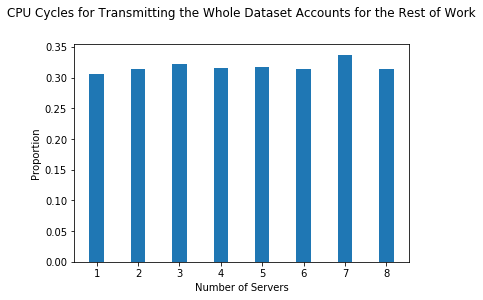

In [6]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] / args[1] for args in p1_args], WIDTH)

ax.set_ylabel('Proportion')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles for Transmitting the Whole Dataset Accounts for the Rest of Work', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

**The above figure shows we can save at most 35% of the CPU cycles consumed by the server program if we perform the data filtering right at the data source.**

We can do the same estimation for the client.

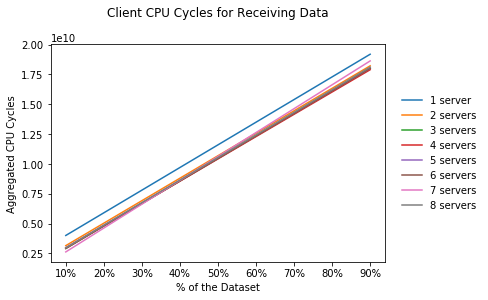

r-squareds: [0.99864099133733153, 0.99963847688366059, 0.99944264502137525, 0.99760271565893466, 0.99869180932076496, 0.99973766085879245, 0.9952374757007596, 0.99986396354622198]


In [7]:
p1_args = []
r_squareds = []

for num_servs in range(1, len(df.index) + 1):
    client_cycle_avgs = \
        [df[size][num_servs]['cycles']['client']['avg'] for size in df.columns[1:]]
    
    slope, intercept, r_value, p_value, std_err = linregress(pstgs, client_cycle_avgs)
    r_squareds.append(r_value**2)
    args = [slope, intercept]
    p1_args.append(args)
    p1 = np.poly1d(args)

    plt.plot(pstgs, p1(pstgs), '-',
             label=str(num_servs) + ' server' + ('s' if num_servs > 1 else ''))

plt.legend(
    loc=5,
    bbox_to_anchor=(1.3, 0.5),
    frameon=False)

plt.ylabel('Aggregated CPU Cycles')
plt.xlabel('% of the Dataset')
plt.xticks(pstgs, [str(int(ps * 100)) + '%' for ps in pstgs])
plt.title('Client CPU Cycles for Receiving Data', y=1.1)

plt.show()

print('r-squareds: ' + repr(r_squareds))

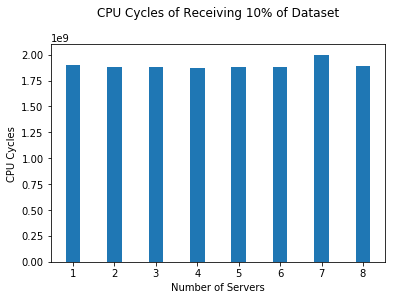

In [8]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] * 0.1 for args in p1_args], WIDTH)

ax.set_ylabel('CPU Cycles')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles of Receiving 10% of Dataset', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

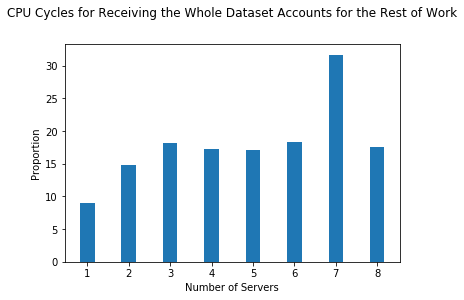

In [9]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] / args[1] for args in p1_args], WIDTH)

ax.set_ylabel('Proportion')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles for Receiving the Whole Dataset Accounts for the Rest of Work', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

The above figure makes sense because we assume the client program would use most of the time/resources just for receiving the date.